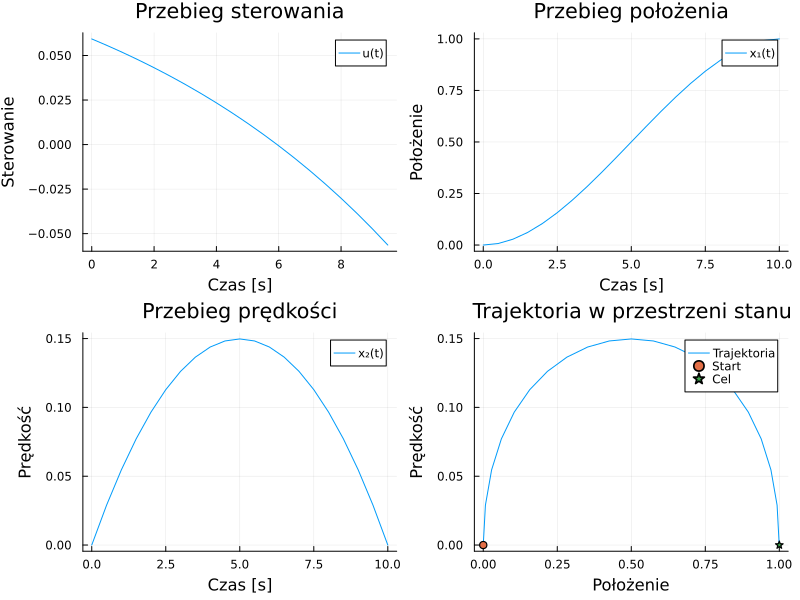


Wyniki optymalizacji:
---------------------
Koszt energii: 0.02645
Błąd końcowy: 0.000293
Suma zmian sterowania: 0.115722
Maksymalne sterowanie: 0.059307

Stan końcowy:
-------------
Położenie końcowe: 0.999707
Prędkość końcowa: -3.0e-6
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 20, constraints m = 2
          nnz(P) + nnz(A) = 60
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination

In [28]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)] # jak układ ewoluuje w czasie bez sterowania
# Wymiar 2x2, gdzie:
# A[1,1] = 1
# A[1,2] = 1/α*(exp(α * Δ)-1)
# A[2,1] = 0
# A[2,2] = exp(α * Δ)


B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1] #  jak sterowanie wpływa na układ

# Obliczenie macierzy R
# Macierz R pozwala powiązać sekwencję sterowań z końcowym stanem układu
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N) 

# Przykład numeryczny:
# Dla N = 3:
# CopyR = [A²B  AB  B]
# Gdzie:
# Pierwsza kolumna: wpływ pierwszego sterowania
# Druga kolumna: wpływ drugiego sterowania
# Trzecia kolumna: wpływ trzeciego sterowania

# Rozwiązanie problemu optymalizacji
model = Model(OSQP.Optimizer)
@variable(model, μ[1:N])
@objective(model, Min, μ' * μ)
@constraint(model, R * μ .== xf - A^N * x0)
optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
display(plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600)))


# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

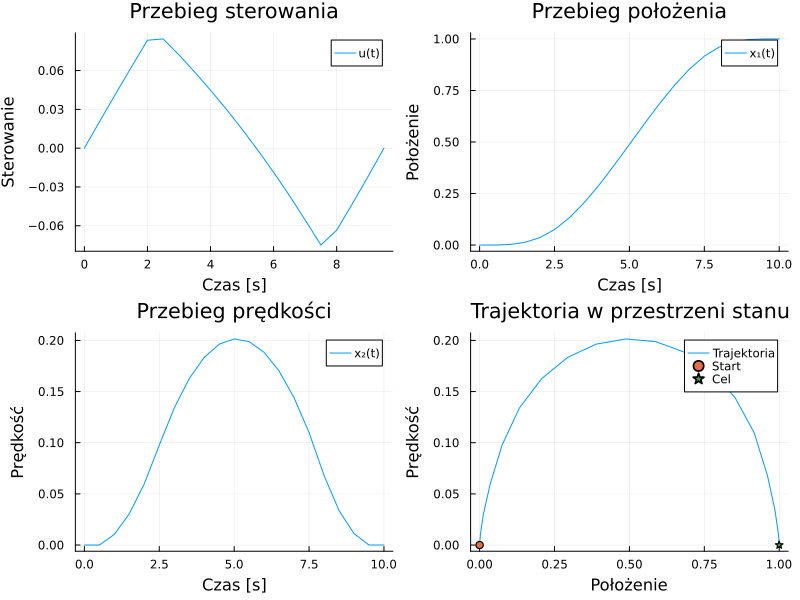

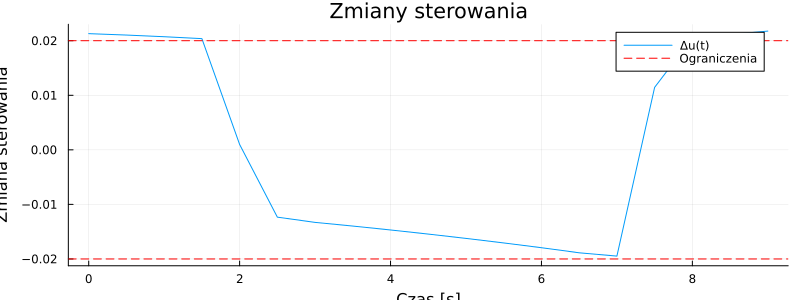


Wyniki optymalizacji:
---------------------
Koszt energii: 0.048821
Błąd końcowy: 1.0e-6
Suma zmian sterowania: 0.3187
Maksymalne sterowanie: 0.084444

Stan końcowy:
-------------
Położenie końcowe: 0.999999
Prędkość końcowa: 0.0
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 20, constraints m = 42
          nnz(P) + nnz(A) = 138
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off

In [42]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu (takie same jak w Zadaniu 1)
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Obliczenie macierzy R
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N)

# Macierz D dla ograniczeń na szybkość zmian sterowania
D = zeros(N - 1, N)
for i in 1:N-1
  D[i, i] = -1
  D[i, i+1] = 1
end

# Rozwiązanie problemu optymalizacji z dodatkowymi ograniczeniami
model = Model(OSQP.Optimizer)

# Zmienne decyzyjne
@variable(model, μ[1:N])

# Funkcja celu - minimalizacja energii
@objective(model, Min, μ' * μ)

# Ograniczenie na stan końcowy
@constraint(model, R * μ .== xf - A^N * x0)

# Nowe ograniczenia:
# 1. Pierwsze i ostatnie sterowanie równe 0
@constraint(model, μ[1] == 0)
@constraint(model, μ[N] == 0)

# 2. Ograniczenie na szybkość zmian sterowania
@constraint(model, D * μ .<= 0.02)
@constraint(model, D * μ .>= -0.02)

optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))
display(p_main)

# Następnie wyświetl wykres zmian sterowania
Δu = diff(u_opt)
p5 = plot(t_u[1:end-1], Δu,
  label="Δu(t)",
  xlabel="Czas [s]",
  ylabel="Zmiana sterowania",
  title="Zmiany sterowania",
  legend=:topright,
  size=(800, 300))
hline!([0.02, -0.02], label="Ograniczenia", linestyle=:dash, color=:red)
display(p5)

# Wyświetlenie wszystkich wykresów


# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

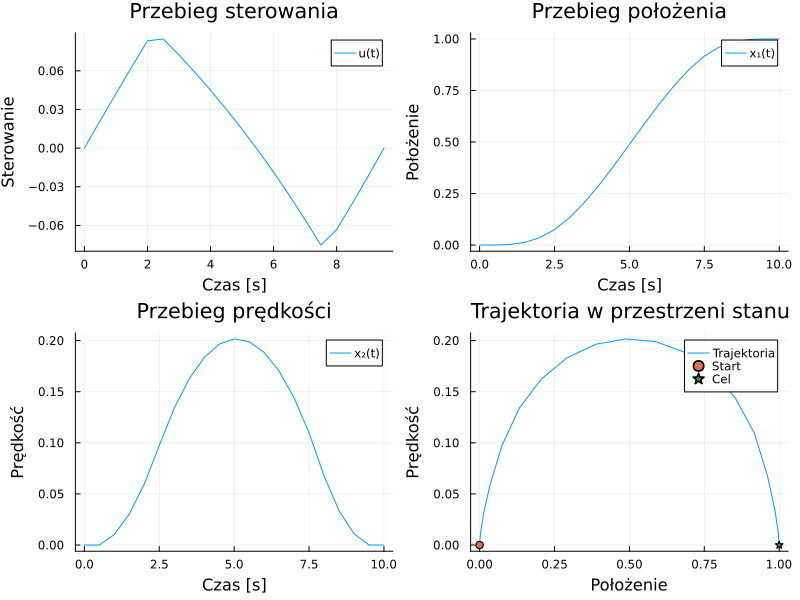

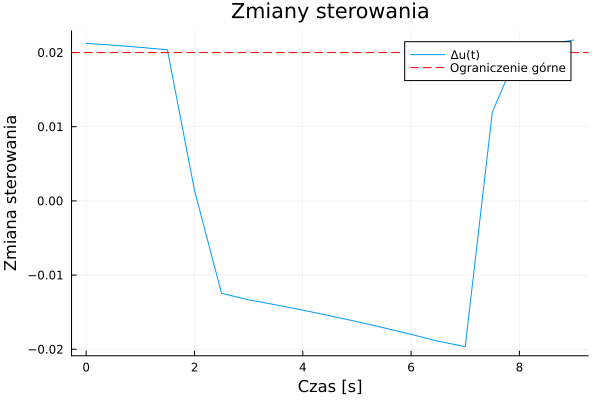


Wyniki optymalizacji:
---------------------
Koszt energii: 0.048919
Błąd końcowy: 1.0e-6
Suma zmian sterowania: 0.319981
Maksymalne sterowanie: 0.084748

Stan końcowy:
-------------
Położenie końcowe: 0.999999
Prędkość końcowa: 0.0
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 20, constraints m = 23
          nnz(P) + nnz(A) = 100
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: o

In [30]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Obliczenie macierzy R
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N)

# Macierz D dla ograniczeń na szybkość zmian sterowania
D = zeros(N - 1, N)
for i in 1:N-1
  D[i, i] = -1
  D[i, i+1] = 1
end

# Rozwiązanie problemu optymalizacji z dodatkowymi ograniczeniami
model = Model(OSQP.Optimizer)

# Zmienne decyzyjne
@variable(model, μ[1:N])

# Funkcja celu - minimalizacja energii
@objective(model, Min, μ' * μ)

# Ograniczenie na stan końcowy
@constraint(model, R * μ .== xf - A^N * x0)

# Nowe ograniczenia:
# 1. Pierwsze i ostatnie sterowanie równe 0
@constraint(model, μ[1] == 0)
@constraint(model, μ[N] == 0)

# 2. Ograniczenie na szybkość zmian sterowania (tylko górne)
@constraint(model, D * μ .<= 0.02)

optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))
display(p_main)

# Dodatkowy wykres pokazujący zmiany sterowania
Δu = diff(u_opt)
p5 = plot(t_u[1:end-1], Δu, label="Δu(t)", xlabel="Czas [s]", ylabel="Zmiana sterowania",
  title="Zmiany sterowania", legend=:topright)
hline!([0.02], label="Ograniczenie górne", linestyle=:dash, color=:red)
display(p5)

# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])


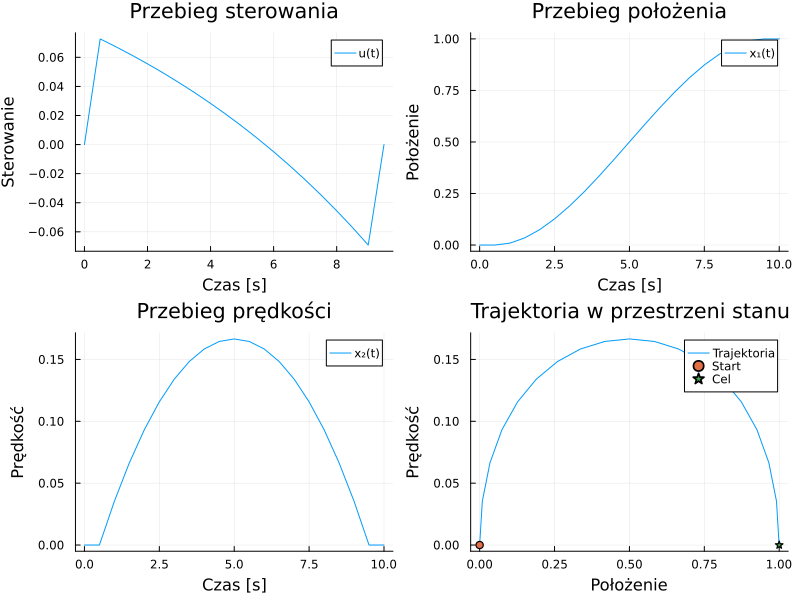

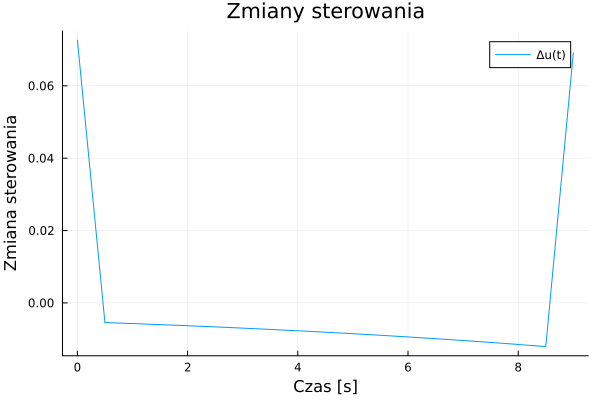


Wyniki optymalizacji:
---------------------
Koszt energii: 0.03568
Błąd końcowy: 0.000289
Suma zmian sterowania: 0.283487
Maksymalne sterowanie: 0.07264

Stan końcowy:
-------------
Położenie końcowe: 0.999711
Prędkość końcowa: -3.0e-6
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 20, constraints m = 4
          nnz(P) + nnz(A) = 62
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination:

In [31]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Obliczenie macierzy R
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N)

# Rozwiązanie problemu optymalizacji
model = Model(OSQP.Optimizer)

# Zmienne decyzyjne
@variable(model, μ[1:N])

# Funkcja celu - minimalizacja energii
@objective(model, Min, μ' * μ)

# Ograniczenie na stan końcowy
@constraint(model, R * μ .== xf - A^N * x0)

# Ograniczenia na pierwsze i ostatnie sterowanie
@constraint(model, μ[1] == 0)
@constraint(model, μ[N] == 0)

optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))
display(p_main)

# Dodatkowy wykres pokazujący zmiany sterowania
Δu = diff(u_opt)
p5 = plot(t_u[1:end-1], Δu, label="Δu(t)", xlabel="Czas [s]", ylabel="Zmiana sterowania",
  title="Zmiany sterowania", legend=:topright)
display(p5)
# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

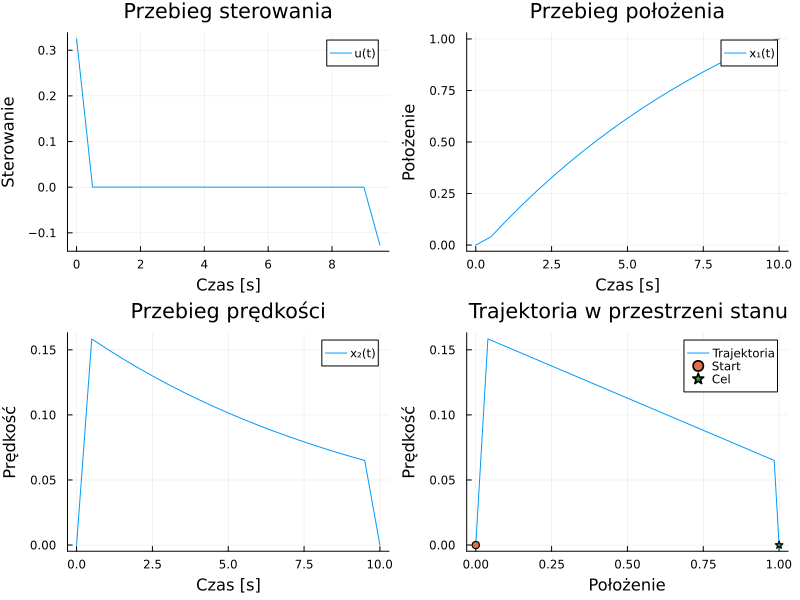

Całkowity wydatek sterowania: 0.4535000162615198

Wyniki optymalizacji:
---------------------
Koszt energii: 0.121545
Błąd końcowy: 0.0
Suma zmian sterowania: 0.451526
Maksymalne sterowanie: 0.324776

Stan końcowy:
-------------
Położenie końcowe: 1.0
Prędkość końcowa: -0.0
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 40, constraints m = 42
          nnz(P) + nnz(A) = 120
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
  

In [32]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Obliczenie macierzy R
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N)

# Rozwiązanie problemu optymalizacji
model = Model(OSQP.Optimizer)

# Zmienne decyzyjne
@variable(model, μ[1:N])
@variable(model, z[1:N])  # zmienne pomocnicze do normy L1

# Funkcja celu - minimalizacja wydatku (norma L1)
@objective(model, Min, sum(z))

# Ograniczenia dla normy L1
@constraint(model, z .>= μ)
@constraint(model, z .>= -μ)

# Ograniczenie na stan końcowy
@constraint(model, R * μ .== xf - A^N * x0)

optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))
display(p_main)

# Wyświetlenie sumy wartości bezwzględnych sterowania (wydatek)
println("Całkowity wydatek sterowania: ", sum(abs.(u_opt)))

# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

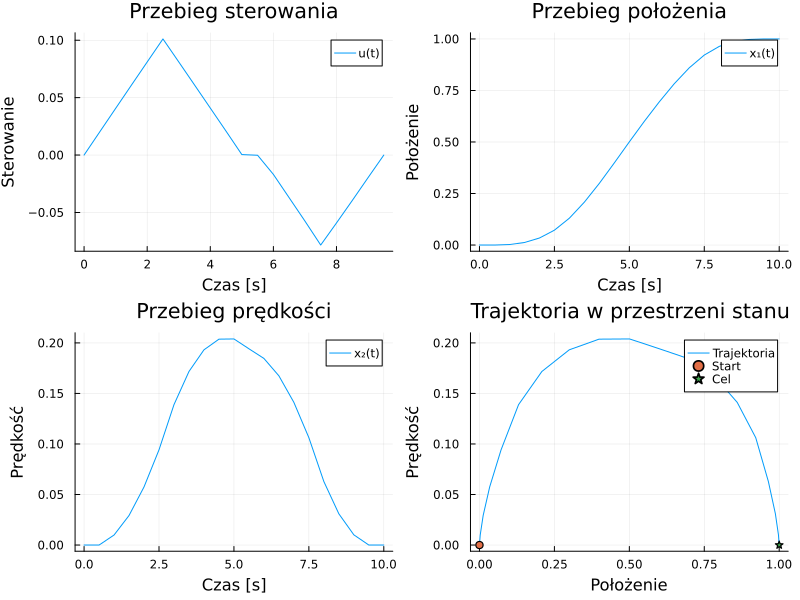

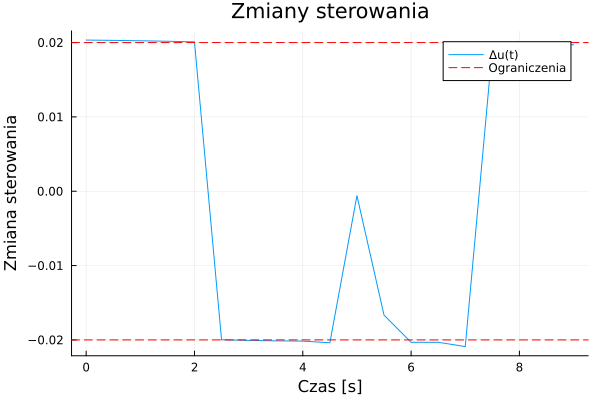

Całkowity wydatek sterowania: 0.8169115704600866

Wyniki optymalizacji:
---------------------
Koszt energii: 0.051559
Błąd końcowy: 0.0
Suma zmian sterowania: 0.359021
Maksymalne sterowanie: 0.101137

Stan końcowy:
-------------
Położenie końcowe: 1.0
Prędkość końcowa: 0.0
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 40, constraints m = 82
          nnz(P) + nnz(A) = 198
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
   

In [33]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Obliczenie macierzy R
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N)

# Macierz D dla ograniczeń na szybkość zmian sterowania
D = zeros(N - 1, N)
for i in 1:N-1
  D[i, i] = -1
  D[i, i+1] = 1
end

# Rozwiązanie problemu optymalizacji
model = Model(OSQP.Optimizer)

# Zmienne decyzyjne
@variable(model, μ[1:N])
@variable(model, z[1:N])  # zmienne pomocnicze do normy L1

# Funkcja celu - minimalizacja wydatku (norma L1)
@objective(model, Min, sum(z))

# Ograniczenia dla normy L1
@constraint(model, z .>= μ)
@constraint(model, z .>= -μ)

# Ograniczenie na stan końcowy
@constraint(model, R * μ .== xf - A^N * x0)

# Ograniczenia na pierwsze i ostatnie sterowanie
@constraint(model, μ[1] == 0)
@constraint(model, μ[N] == 0)

# Ograniczenia na zmiany sterowania
@constraint(model, D * μ .<= 0.02)
@constraint(model, D * μ .>= -0.02)

optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))
display(p_main)

# Dodatkowy wykres pokazujący zmiany sterowania
Δu = diff(u_opt)
p5 = plot(t_u[1:end-1], Δu, label="Δu(t)", xlabel="Czas [s]", ylabel="Zmiana sterowania",
  title="Zmiany sterowania", legend=:topright)
hline!([0.02, -0.02], label="Ograniczenia", linestyle=:dash, color=:red)

# Wyświetlenie sumy wartości bezwzględnych sterowania (wydatek)
println("Całkowity wydatek sterowania: ", sum(abs.(u_opt)))
display(p5)
# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

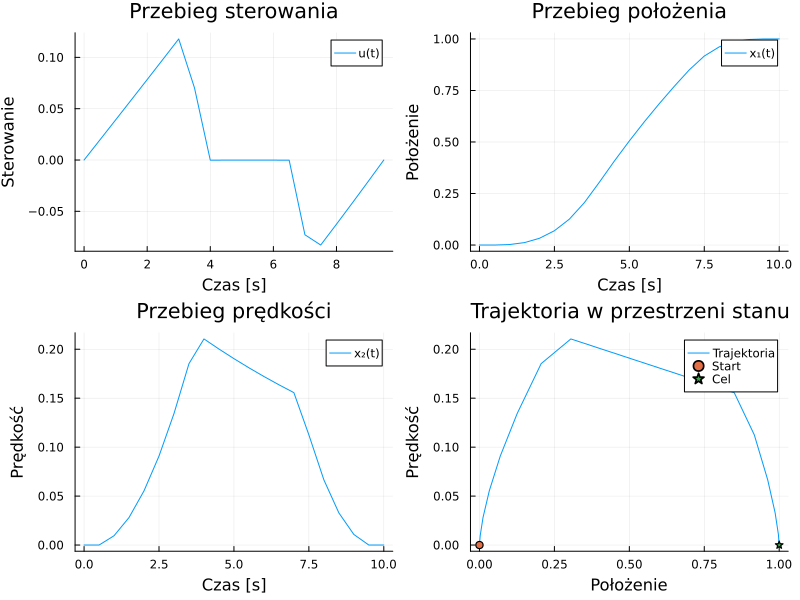

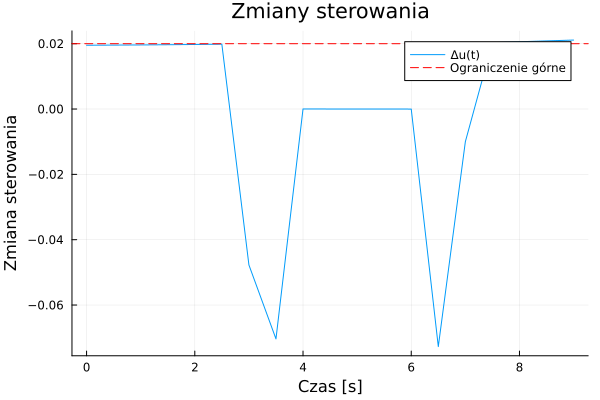

Całkowity wydatek sterowania: 0.7639999240010618

Wyniki optymalizacji:
---------------------
Koszt energii: 0.058263
Błąd końcowy: 0.0
Suma zmian sterowania: 0.401692
Maksymalne sterowanie: 0.117972

Stan końcowy:
-------------
Położenie końcowe: 1.0
Prędkość końcowa: 0.0
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 40, constraints m = 63
          nnz(P) + nnz(A) = 160
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
   

In [34]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Obliczenie macierzy R
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N)

# Macierz D dla ograniczeń na szybkość zmian sterowania
D = zeros(N - 1, N)
for i in 1:N-1
  D[i, i] = -1
  D[i, i+1] = 1
end

# Rozwiązanie problemu optymalizacji
model = Model(OSQP.Optimizer)

# Zmienne decyzyjne
@variable(model, μ[1:N])
@variable(model, z[1:N])  # zmienne pomocnicze do normy L1

# Funkcja celu - minimalizacja wydatku (norma L1)
@objective(model, Min, sum(z))

# Ograniczenia dla normy L1
@constraint(model, z .>= μ)
@constraint(model, z .>= -μ)

# Ograniczenie na stan końcowy
@constraint(model, R * μ .== xf - A^N * x0)

# Ograniczenia na pierwsze i ostatnie sterowanie
@constraint(model, μ[1] == 0)
@constraint(model, μ[N] == 0)

# Ograniczenie na zmiany sterowania (tylko górne)
@constraint(model, D * μ .<= 0.02)

optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))
display(p_main)

# Dodatkowy wykres pokazujący zmiany sterowania
Δu = diff(u_opt)
p5 = plot(t_u[1:end-1], Δu, label="Δu(t)", xlabel="Czas [s]", ylabel="Zmiana sterowania",
  title="Zmiany sterowania", legend=:topright)
hline!([0.02], label="Ograniczenie górne", linestyle=:dash, color=:red)

# Wyświetlenie sumy wartości bezwzględnych sterowania (wydatek)
println("Całkowity wydatek sterowania: ", sum(abs.(u_opt)))
display(p5)

# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

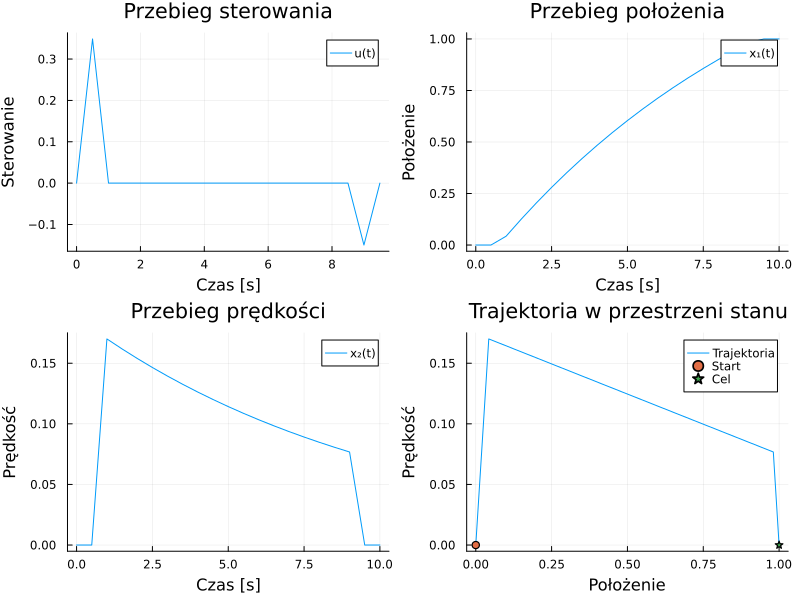

Całkowity wydatek sterowania: 0.49945831511385963

Wyniki optymalizacji:
---------------------
Koszt energii: 0.143964
Błąd końcowy: 0.0
Suma zmian sterowania: 0.996725
Maksymalne sterowanie: 0.348633

Stan końcowy:
-------------
Położenie końcowe: 1.0
Prędkość końcowa: -0.0
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 40, constraints m = 44
          nnz(P) + nnz(A) = 122
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
 

In [35]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Obliczenie macierzy R
function calculate_R(A, B, N)
  n = size(A, 1)
  R = zeros(n, N)
  for i in 1:N
    R[:, i] = A^(N - i) * B
  end
  return R
end

R = calculate_R(A, B, N)

# Rozwiązanie problemu optymalizacji
model = Model(OSQP.Optimizer)

# Zmienne decyzyjne
@variable(model, μ[1:N])
@variable(model, z[1:N])  # zmienne pomocnicze do normy L1

# Funkcja celu - minimalizacja wydatku (norma L1)
@objective(model, Min, sum(z))

# Ograniczenia dla normy L1
@constraint(model, z .>= μ)
@constraint(model, z .>= -μ)

# Ograniczenie na stan końcowy
@constraint(model, R * μ .== xf - A^N * x0)

# Ograniczenia na pierwsze i ostatnie sterowanie
@constraint(model, μ[1] == 0)
@constraint(model, μ[N] == 0)

optimize!(model)

# Pobranie optymalnego sterowania
u_opt = value.(μ)

# Symulacja układu dla optymalnego sterowania
function simulate_system(A, B, x0, u, N)
  n = size(A, 1)
  X = zeros(n, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

X = simulate_system(A, B, x0, u_opt, N)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, u_opt, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))
display(p_main)

# Wyświetlenie sumy wartości bezwzględnych sterowania (wydatek)
println("Całkowity wydatek sterowania: ", sum(abs.(u_opt)))

# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

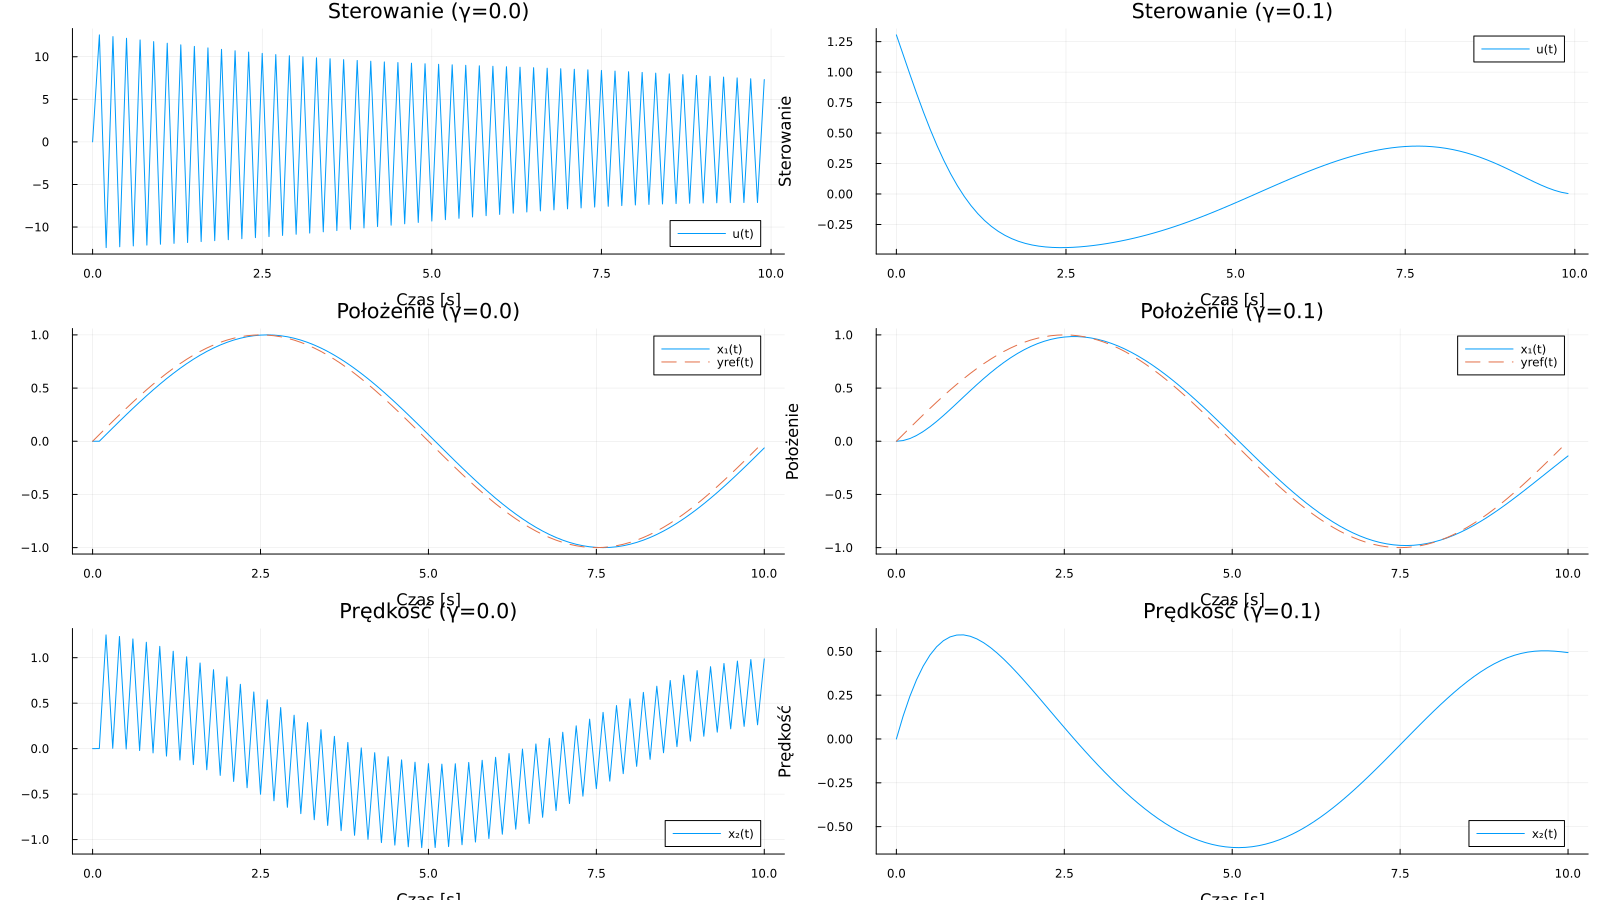


Wyniki optymalizacji:
---------------------
Koszt energii: 0.048821
Błąd końcowy: 1.0e-6
Suma zmian sterowania: 0.3187
Maksymalne sterowanie: 0.084444

Stan końcowy:
-------------
Położenie końcowe: 0.999999
Prędkość końcowa: 0.0
Oczekiwane położenie: 1.0
Oczekiwana prędkość: 0.0
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 302, constraints m = 202
          nnz(P) + nnz(A) = 802
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: o

In [43]:
using LinearAlgebra
using Plots
using JuMP
using OSQP

# Parametry układu
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.1    # okres próbkowania [s]
kf = 100   # horyzont
ω = 2π / 10  # częstotliwość sygnału referencyjnego

# Stan początkowy
x0 = [0.0; 0.0]

# Obliczenie macierzy układu ciągłego
α = -β / m
Ac = [0 1; 0 α]
Bc = [0; 1 / m]
C = [1 0]

# Obliczenie macierzy układu dyskretnego
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Generacja trajektorii referencyjnej
t = 0:Δ:(kf*Δ)
yref = sin.(ω .* t[1:end-1])

# Funkcja do rozwiązania problemu optymalizacji
function solve_tracking_problem(γ)
  # Model optymalizacji
  model = Model(OSQP.Optimizer)

  # Zmienne decyzyjne
  @variable(model, u[1:kf])
  @variable(model, x[1:2, 1:kf+1])

  # Funkcja celu
  @objective(model, Min,
    sum((x[1, k+1] - yref[k])^2 for k in 1:kf) +
    γ * sum(u[k]^2 for k in 1:kf))

  # Ograniczenia
  @constraint(model, [j = 1:2], x[j, 1] == x0[j])

  # Dynamika układu
  for k in 1:kf
    @constraint(model, x[1, k+1] == A[1, 1] * x[1, k] + A[1, 2] * x[2, k] + B[1] * u[k])
    @constraint(model, x[2, k+1] == A[2, 1] * x[1, k] + A[2, 2] * x[2, k] + B[2] * u[k])
  end

  optimize!(model)
  return value.(u), value.(x)
end

# Rozwiązanie dla γ = 0
u_opt1, x_opt1 = solve_tracking_problem(0.0)

# Rozwiązanie dla γ = 0.1
u_opt2, x_opt2 = solve_tracking_problem(0.1)

# Tworzenie wykresów
function plot_results(u_opt, x_opt, γ)
  p1 = plot(t[1:end-1], u_opt, label="u(t)", xlabel="Czas [s]",
    ylabel="Sterowanie", title="Sterowanie (γ=$γ)")

  p2 = plot(t, x_opt[1, :], label="x₁(t)", xlabel="Czas [s]",
    ylabel="Położenie", title="Położenie (γ=$γ)")
  plot!(p2, t[1:end-1], yref, label="yref(t)", linestyle=:dash)

  p3 = plot(t, x_opt[2, :], label="x₂(t)", xlabel="Czas [s]",
    ylabel="Prędkość", title="Prędkość (γ=$γ)")

  plot(p1, p2, p3, layout=(3, 1), size=(800, 900))
end

# Wykresy dla obu przypadków
p1 = plot_results(u_opt1, x_opt1, 0.0)
p2 = plot_results(u_opt2, x_opt2, 0.1)
display(plot(p1, p2, layout=(1, 2), size=(1600, 900)))

# Obliczenie kosztów
# Koszt energii (norma kwadratowa sterowania)
energy_cost = sum(u_opt .^ 2)

# Błąd końcowy (odległość od stanu docelowego)
final_error = norm(X[:, end] - xf)

# Całkowita zmiana sterowania
control_changes = sum(abs.(diff(u_opt)))

# Maksymalna wartość sterowania
max_control = maximum(abs.(u_opt))

# Wyświetlenie wyników
println("\nWyniki optymalizacji:")
println("---------------------")
println("Koszt energii: ", round(energy_cost, digits=6))
println("Błąd końcowy: ", round(final_error, digits=6))
println("Suma zmian sterowania: ", round(control_changes, digits=6))
println("Maksymalne sterowanie: ", round(max_control, digits=6))

# Możemy też dodać statystyki stanu końcowego
println("\nStan końcowy:")
println("-------------")
println("Położenie końcowe: ", round(X[1, end], digits=6))
println("Prędkość końcowa: ", round(X[2, end], digits=6))
println("Oczekiwane położenie: ", xf[1])
println("Oczekiwana prędkość: ", xf[2])

ALG GENETYCZNY

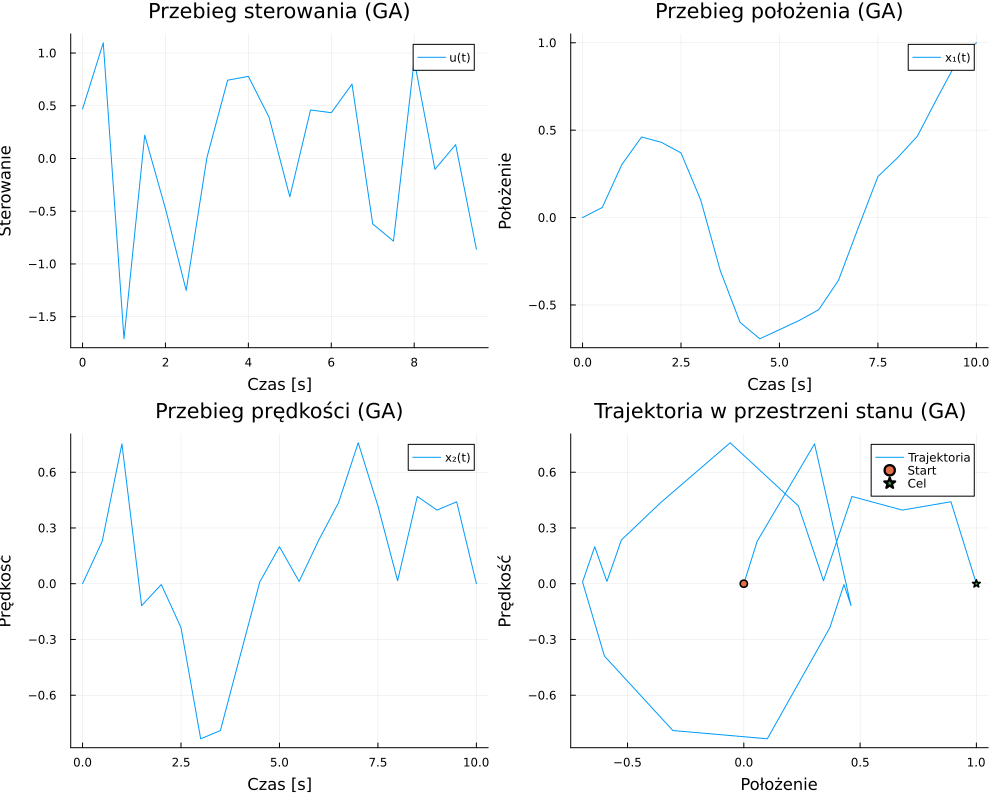

Energia sterowania: 11.159560885220277
Błąd końcowy: 2.455829612839087e-5


In [41]:
using Plots
using Random
using Statistics
using LinearAlgebra

# Parametry układu (takie same jak wcześniej)
m = 1.0    # masa [kg]
β = 0.1    # współczynnik tarcia [Ns/m]
Δ = 0.5    # okres próbkowania [s]
tf = 10.0  # czas końcowy [s]
N = Int(tf / Δ)  # horyzont

# Stan początkowy i końcowy
x0 = [0.0; 0.0]
xf = [1.0; 0.0]

# Obliczenie macierzy układu
α = -β / m
A = [1 1/α*(exp(α * Δ)-1); 0 exp(α * Δ)]
B = -1 / β * [1 / α * (exp(α * Δ) - 1) - Δ; exp(α * Δ) - 1]

# Parametry algorytmu genetycznego
population_size = 1000
num_generations = 1000
mutation_rate = 0.01
elite_size = 5

# Funkcja do symulacji układu
function simulate_system(u)
  X = zeros(2, N + 1)
  X[:, 1] = x0

  for k in 1:N
    X[:, k+1] = A * X[:, k] + B * u[k]
  end

  return X
end

# Funkcja przystosowania (fitness)
function fitness(u)
  X = simulate_system(u)
  final_state_error = norm(X[:, end] - xf)
  control_energy = sum(u .^ 2)

  # Kara za błąd stanu końcowego
  penalty = 1000.0 * final_state_error

  return -(control_energy + penalty)
end

# Inicjalizacja populacji
function initialize_population()
  return [randn(N) for _ in 1:population_size]
end

# Selekcja rodziców
function select_parents(population, fitness_values)
  # Turniej
  tournament_size = 3
  parent_indices = zeros(Int, 2)

  for i in 1:2
    candidates = rand(1:population_size, tournament_size)
    parent_indices[i] = candidates[argmax(fitness_values[candidates])]
  end

  return population[parent_indices[1]], population[parent_indices[2]]
end

# Krzyżowanie
function crossover(parent1, parent2)
  crossover_point = rand(1:N)
  child1 = vcat(parent1[1:crossover_point], parent2[crossover_point+1:end])
  child2 = vcat(parent2[1:crossover_point], parent1[crossover_point+1:end])
  return child1, child2
end

# Mutacja
function mutate!(individual)
  for i in 1:N
    if rand() < mutation_rate
      individual[i] += randn() * 0.1
    end
  end
end

# Główna pętla algorytmu genetycznego
function genetic_algorithm()
  # Inicjalizacja
  population = initialize_population()
  best_solution = nothing
  best_fitness = -Inf
  fitness_history = Float64[]

  for generation in 1:num_generations
    # Obliczenie przystosowania
    fitness_values = [fitness(ind) for ind in population]

    # Zapisanie najlepszego rozwiązania
    max_fitness = maximum(fitness_values)
    push!(fitness_history, max_fitness)

    if max_fitness > best_fitness
      best_fitness = max_fitness
      best_solution = copy(population[argmax(fitness_values)])
    end

    # Nowa populacja
    new_population = typeof(population)()

    # Elityzm
    sorted_indices = sortperm(fitness_values, rev=true)
    for i in 1:elite_size
      push!(new_population, copy(population[sorted_indices[i]]))
    end

    # Krzyżowanie i mutacja
    while length(new_population) < population_size
      parent1, parent2 = select_parents(population, fitness_values)
      child1, child2 = crossover(parent1, parent2)
      mutate!(child1)
      mutate!(child2)
      push!(new_population, child1)
      push!(new_population, child2)
    end

    # Przycinanie do rozmiaru populacji
    while length(new_population) > population_size
      pop!(new_population)
    end

    population = new_population
  end

  return best_solution, fitness_history
end

# Uruchomienie algorytmu
best_solution, fitness_history = genetic_algorithm()

# Symulacja dla najlepszego rozwiązania
X = simulate_system(best_solution)

# Tworzenie wykresów
t = 0:Δ:tf
t_u = 0:Δ:(tf-Δ)

# Wykres sterowania
p1 = plot(t_u, best_solution, label="u(t)", xlabel="Czas [s]", ylabel="Sterowanie",
  title="Przebieg sterowania (GA)", legend=:topright)

# Wykres położenia
p2 = plot(t, X[1, :], label="x₁(t)", xlabel="Czas [s]", ylabel="Położenie",
  title="Przebieg położenia (GA)", legend=:topright)

# Wykres prędkości
p3 = plot(t, X[2, :], label="x₂(t)", xlabel="Czas [s]", ylabel="Prędkość",
  title="Przebieg prędkości (GA)", legend=:topright)

# Wykres trajektorii w przestrzeni stanu
p4 = plot(X[1, :], X[2, :], label="Trajektoria", xlabel="Położenie", ylabel="Prędkość",
  title="Trajektoria w przestrzeni stanu (GA)", legend=:topright)
scatter!([x0[1]], [x0[2]], label="Start", marker=:circle)
scatter!([xf[1]], [xf[2]], label="Cel", marker=:star)

# Wykres historii fitness
p5 = plot(1:num_generations, fitness_history, label="Fitness",
  xlabel="Generacja", ylabel="Wartość fitness",
  title="Historia fitness", legend=:bottomright)

# Wyświetlenie wszystkich wykresów
p_main = plot(p1, p2, p3, p4, layout=(2, 2), size=(1000, 800))

# Wyświetlenie wyników
println("Energia sterowania: ", sum(best_solution .^ 2))
println("Błąd końcowy: ", norm(X[:, end] - xf))
display(p_main)

